# K-means clustering - Tutorial


Clustering is an unsupervised problem because the goal is to discover structure on the basis of data sets. Clustering looks to find homogeneous subgroups among the observations. 

K-means is an unsupervised clustering method. The main idea is to separate the data points into K dinstinct clusters. We then have two problems to solve. First, we need to find the k centroids of the k clusters. Then, we need to affect each data point to the cluster which centroid is the closest to the data point.

The algorithm is the following:

* Choose the number k of clusters
* Initialize the clusters and calculate the feature mean as initial the clusters centroid
* Iterate until convergence (e.g. cluster assignemnt stops changing):
  - Assign each data point to its corresponding cluster ID
  - Compute the value of the objective function (sum ove the clusters of the distances between the points and the cluster centroids)
  - Update the centers of the clusters
The solution will converge to a local minimum. Consequently, the result depends on the initial stage. It is prudent to perform the algorithm several times with different initial configurations.
  
The results depends on the initial step because only local min

Import useful Python packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from math import cos, sin, pi, sqrt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.decomposition import PCA

Set seed for reproducibility

In [2]:
random.seed(0)

Import data

Text(0.5, 0.92, 'PNSN catalog')

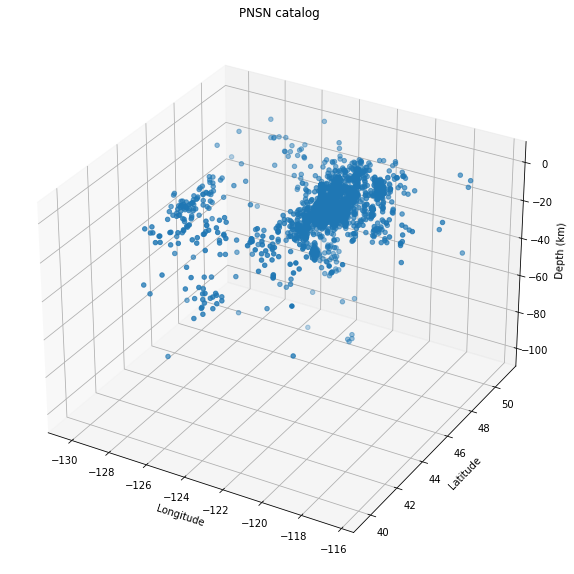

In [3]:
catalog = pd.read_csv('pnsn_catalog.csv')
catalog.drop(columns=['Evid', 'Magnitude', 'Magnitude Type', 'Epoch(UTC)', 'Time UTC', 'Time Local', 'Distance From', 'Depth Mi'], inplace=True)
catalog.columns = ['latitude', 'longitude', 'depth']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(catalog['longitude'], catalog['latitude'], -catalog['depth'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
plt.title('PNSN catalog')

In [4]:
data = catalog.to_numpy()

In the following, we denote $n$ the number of data points, and $p$ the number of features for each data point.

In [5]:
n = np.shape(data)[0]
p = np.shape(data)[1]
print('We have {:d} data points, and each one has {:d} features'.format(n, p))

We have 3202 data points, and each one has 3 features


Let us define a function to initialize the centroid of the clusters. We choose random points within the range of values taken by the data.

In [6]:
def init_centers(data, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Loop on k centers
    for i in range(0, k):
        # Generate p random values between 0 and 1
        dist = np.random.uniform(size=np.shape(data)[1])
        # Use the random values to generate a point within the range of values taken by the data
        centers[i, :] = np.min(data, axis=0) + (np.max(data, axis=0) - np.min(data, axis=0)) * dist
    return centers

To be able to affect each data point to the closest centroid, we need to define the distance between two data points. The most common distance is the **Euclidean distance**:

$d(x,y) = \sqrt{\sum_{i = 1}^p (x_i - y_i)^2}$

where $x$ and $y$ are two data observation points with $p$ variables. There exist many other distance metrics, which can be called from the ``DistanceMetric`` sci-kit learn module. You can find a review here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

We then define a function to compute the distance between each data point and each centroid.

In [7]:
def compute_distance(data, centers, k):
    """
    """
    # Initialize distance
    distance = np.zeros((np.shape(data)[0], k))
    # Loop on n data points
    for i in range(0, np.shape(data)[0]):
        # Loop on k centroids
        for j in range(0, k):
            # Compute distance
            distance[i, j] = sqrt(np.sum(np.square(data[i, :] - centers[j, :])))
    return distance

We now define a function to affect each data point to the cluster which centroid is the closest to the point. We also define an objective function that will be minimized until we reach convergence.

Our objective is to minimize the sum of the square of the distance between each point and the closest centroid:

$obj = \sum_{j = 1}^k \sum_{i = 1}^{N_j} d(x^{(i)} , x^{(j)}) ^2$

where $x^{(i)}$ is the $i^{th}$ point in the cluster $j$, $x^{(j)}$ is the centroid of the cluster $j$, and $N_j$ is the number of points in the cluster $j$.

In [8]:
def compute_objective(distance, clusters):
    """
    """
    # Initialize objective
    objective = 0.0
    # Loop on n data points
    for i in range(0, np.shape(distance)[0]):
        # Add distance to the closest centroid
        objective = objective + distance[i, int(clusters[i])] ** 2.0
    return objective

In [9]:
def compute_clusters(distance):
    """
    """
    # Initialize clusters
    clusters = np.zeros(np.shape(distance)[0])
    # Loop on n data points
    for i in range(0, np.shape(distance)[0]):
        # Find closest centroid
        best = np.argmin(distance[i, :])
        # Assign data point to corresponding cluster
        clusters[i] = best
    return clusters

After all points are assigned to a cluster, compute the new location of the centroid. It is just the value of the mean of all the points affected to that cluster:

For $1 \leq j \leq k$, $x_p^{(j)} = \frac{1}{N_j} \sum_{i = 1}^{N_j} x_p^{(i)}$

In [10]:
def compute_centers(data, clusters, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Loop on clusters
    for i in range(0, k):
        # Select all data points in this cluster
        subdata = data[clusters == i, :]
        # If no data point in this cluster, generate randomly a new centroid
        if (np.shape(subdata)[0] == 0):
            centers[i, :] = init_centers(data, 1)
        else:
            # Compute the mean location of all data points in this cluster
            centers[i, :] = np.mean(subdata, axis=0)
    return centers

We can now code the K-means algorithm by assembling all these functions. We stop the computation when the objective function no longer decreases.

In [11]:
def kmeans(data, k):
    """
    """
    # Initialize centroids
    centers = init_centers(data, k)
    # Initialize objective function to maximum square of distance between to data points time number od data points
    objective_old = np.shape(data)[0] * np.sum(np.square(np.max(data, axis=0) - np.min(data, axis=0)))
    # Initialize clusters
    clusters_old = np.zeros(np.shape(data)[0])
    # Start loop until convergence
    stop_alg = False
    while stop_alg == False:
        # Compute distance between data points and centroids
        distance = compute_distance(data, centers, k)
        # Get new clusters
        clusters_new = compute_clusters(distance)
        # get new value of objective function
        objective_new = compute_objective(distance, clusters_new)
        # If objective function stops decreasing, end loop
        if objective_new >= objective_old:
            return (clusters_old, objective_old, centers)
        else:
            # Update the locations of the centroids
            centers = compute_centers(data, clusters_new, k)
            objective_old = objective_new
            clusters_old = clusters_new

Run K-means with 4 clusters

Text(0.5, 0.92, 'Clusters for PNSN catalog')

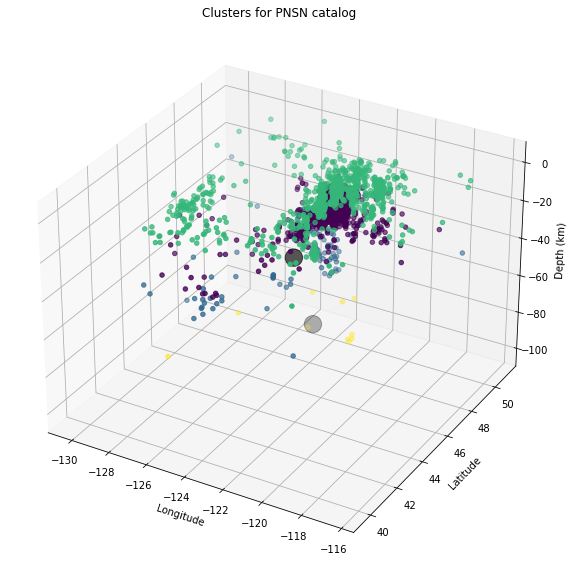

In [12]:
k = 4
(clusters, objective, centers) = kmeans(data, k)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 0], -data[:, 2], c=clusters)
ax.scatter(centers[:, 1], centers[:, 0], -centers[:, 2], marker='o', s=300, c='black')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
plt.title('Clusters for PNSN catalog')

The range of variations is higher for depth than for latitude and longitude. The algorithm tends to divide the catalog by depth, and does not seem to take into account latitude and longitude. You can transform latitude and longitude into distance into kilometers before clustering.

In [13]:
a = 6378.136
e = 0.006694470
lat0 = 45
lon0 = -123
dx = (pi / 180.0) * a * cos(lat0 * pi / 180.0) / sqrt(1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0))
dy = (3.6 * pi / 648.0) * a * (1.0 - e * e) / ((1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0)) ** 1.5)
catalog['x'] = dx * (catalog['longitude'] - lon0)
catalog['y'] = dy * (catalog['latitude'] - lat0)
catalog_xyz = catalog.drop(columns=['latitude', 'longitude'])

Let us see what the catalog looks like now.

Text(0.5, 0.92, 'PNSN catalog')

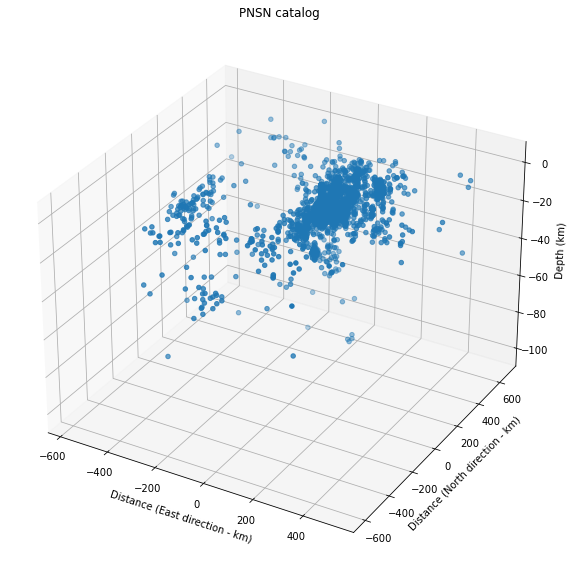

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(catalog_xyz['x'], catalog_xyz['y'], -catalog_xyz['depth'])
ax.set_xlabel('Distance (East direction - km)')
ax.set_ylabel('Distance (North direction - km)')
ax.set_zlabel('Depth (km)')
plt.title('PNSN catalog')

Let us apply k-means clustering to the new catalog in km.

Text(0.5, 0.92, 'Clusters for PNSN catalog')

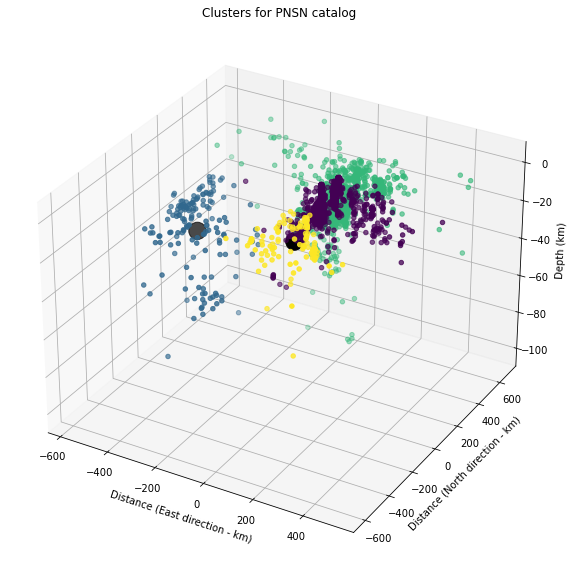

In [15]:
data = catalog_xyz.to_numpy()
(clusters, objective, centers) = kmeans(data, k)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 2], -data[:, 0], c=clusters)
ax.scatter(centers[:, 1], centers[:, 2], -centers[:, 0], marker='o', s=300, c='black')
ax.set_xlabel('Distance (East direction - km)')
ax.set_ylabel('Distance (North direction - km)')
ax.set_zlabel('Depth (km)')
plt.title('Clusters for PNSN catalog')

Now, it seems that the clustering does not take into account the depth, and just divide the regions in blocks according to latitude and longitude. Let us have a closer look at the data.

In [16]:
m = data.mean(axis=0)
m

array([ 10.2229544 ,  67.85986269, 176.39190249])

In [17]:
s = data.std(axis=0)
s

array([ 10.50948328, 110.41407207, 176.80852674])

The standard deviation is much higher for the distance along the East and North direction than for the depth. Let us normalize the data before clustering.

In [18]:
data_norm = (data - m) / s

Text(0.5, 0.92, 'Clusters for PNSN catalog')

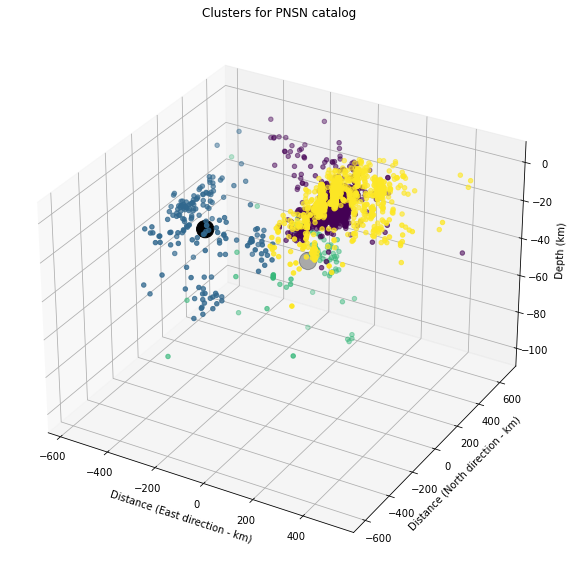

In [19]:
(clusters, objective, centers) = kmeans(data_norm, k)
centers_norm = centers * s + m
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 2], -data[:, 0], c=clusters)
ax.scatter(centers_norm[:, 1], centers_norm[:, 2], -centers_norm[:, 0], marker='o', s=300, c='black')
ax.set_xlabel('Distance (East direction - km)')
ax.set_ylabel('Distance (North direction - km)')
ax.set_zlabel('Depth (km)')
plt.title('Clusters for PNSN catalog')

The end result is very dependent on the choice of the initial centroids. Run next cells several times to see the variations of the clusters.

[[   4.49830856  117.16702651  158.33516486]
 [  18.33373984   32.31868042  286.33916675]
 [  48.61204819  -49.97361758  256.66375145]
 [  10.23097826 -211.73565029 -256.33623008]]


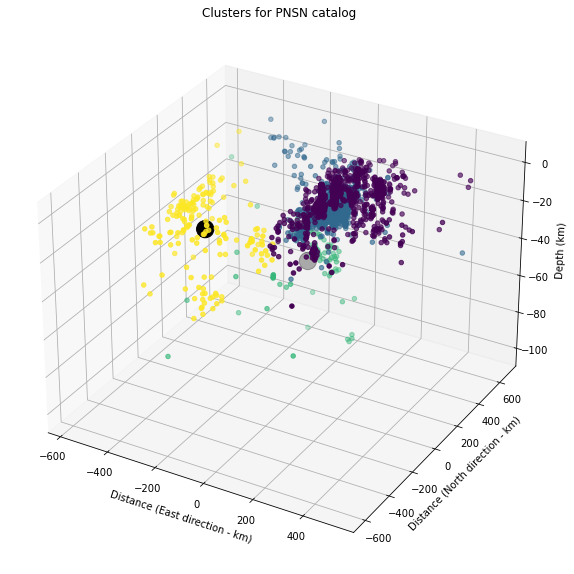

In [20]:
(clusters, objective, centers) = kmeans(data_norm, k)
centers_norm = centers * s + m
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 2], -data[:, 0], c=clusters)
ax.scatter(centers_norm[:, 1], centers_norm[:, 2], -centers_norm[:, 0], marker='o', s=300, c='black')
ax.set_xlabel('Distance (East direction - km)')
ax.set_ylabel('Distance (North direction - km)')
ax.set_zlabel('Depth (km)')
plt.title('Clusters for PNSN catalog')
print(centers_norm)

Result is very sensitive to the location of the initial centroid. Repeat the clustering N times and choose the clustering with the best objective function

In [21]:
def repeat_kmeans(data, k, N):
    """
    """
    # Initialization
    objective = np.zeros(N)
    clusters = np.zeros((N, np.shape(data)[0]))
    centers = np.zeros((N, k, np.shape(data)[1]))
    # Run K-means N times
    for i in range(0, N):
        result = kmeans(data, k)
        clusters[i, :] = result[0]
        objective[i] = result[1]
        centers[i, :, :] = result[2]
    # Choose the clustering with the best value of the objective function
    best = np.argmin(objective)
    return (clusters[best, :], objective[best], centers[best, :, :])

Repeat K-means 100 times

Text(0.5, 0.92, 'Clusters for PNSN catalog')

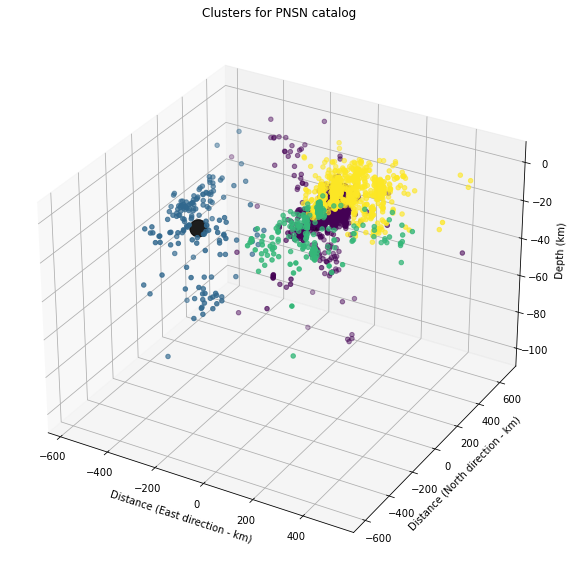

In [22]:
N = 100
(clusters, objective, centers) = repeat_kmeans(data_norm, k, N)
centers_norm = centers * s + m
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 2], -data[:, 0], c=clusters)
ax.scatter(centers_norm[:, 1], centers_norm[:, 2], -centers_norm[:, 0], marker='o', s=300, c='black')
ax.set_xlabel('Distance (East direction - km)')
ax.set_ylabel('Distance (North direction - km)')
ax.set_zlabel('Depth (km)')
plt.title('Clusters for PNSN catalog')

## K-means++

Another solution to avoid the sensitivity to initial choice of centroids is using K-means++. K-means++ is another way to initialize the centroids. The procedure is as follows:

Define $D(x)$ the shortest distance between a data point $x$ and the centroids already defined. Then:

- Take one center $c_1$, chosen from a random of all data points (uniform selection)
- Take a new center $c_i$, choosing a data point $x$ with probability $\frac{D(x)^2}{\sum D(x)^2}$
- Repeat until we have taken k centroids altogether

In [23]:
def init_centers_pp(data, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Choose randomly the first centroid
    index = int(np.shape(data)[0] * np.random.uniform(size=1)[0])
    centers[0, :] = data[index, :]
    # Initialize D
    D = np.zeros(np.shape(data)[0])
    # Loop on remaining centroids
    for i in range(0, k - 1):
        distance = compute_distance(data, centers[0 : (i + 1)], i + 1)
        for j in range(0, np.shape(data)[0]):
            # Find closest centroid
            best = np.argmin(distance[j, :])
            # Get shortest distance
            D[j] = distance[j, int(best)]
        # Cumulative distribution function
        CDF = np.cumsum(np.square(D)) / np.sum(np.square(D))
        # Get index of next centroid
        value = np.random.uniform(size=1)[0]
        for j in range(0, np.shape(data)[0]):
            if value > CDF[j]:
                centers[i + 1, :] = data[j, :]
    return centers

In [24]:
def kmeans_pp(data, k):
    """
    """
    # Initialize centroids
    centers = init_centers_pp(data, k)
    # Initialize objective function to maximum square of distance between to data points time number od data points
    objective_old = np.shape(data)[0] * np.sum(np.square(np.max(data, axis=0) - np.min(data, axis=0)))
    # Initialize clusters
    clusters_old = np.zeros(np.shape(data)[0])
    # Start loop until convergence
    stop_alg = False
    while stop_alg == False:
        # Compute distance between data points and centroids
        distance = compute_distance(data, centers, k)
        # Get new clusters
        clusters_new = compute_clusters(distance)
        # get new value of objective function
        objective_new = compute_objective(distance, clusters_new)
        # If objective function stops decreasing, end loop
        if objective_new >= objective_old:
            return (clusters_old, objective_old, centers)
        else:
            # Update the locations of the centroids
            centers = compute_centers(data, clusters_new, k)
            objective_old = objective_new
            clusters_old = clusters_new

Text(0.5, 0.92, 'Clusters for PNSN catalog')

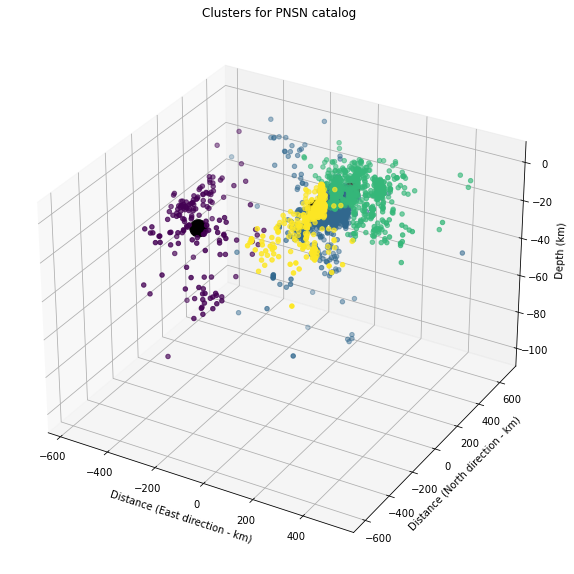

In [25]:
(clusters, objective, centers) = kmeans_pp(data_norm, k)
centers_norm = centers * s + m
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 2], -data[:, 0], c=clusters)
ax.scatter(centers_norm[:, 1], centers_norm[:, 2], -centers_norm[:, 0], marker='o', s=300, c='black')
ax.set_xlabel('Distance (East direction - km)')
ax.set_ylabel('Distance (North direction - km)')
ax.set_zlabel('Depth (km)')
plt.title('Clusters for PNSN catalog')

## Choice of number of clusters

The elbow method is designed to find the optimal number of clusters. It consists in performing the clustering algorithm with an increasing number of clusters $k$ and select and measuring the average distance between data points and the cluster centroids. For each value of $k$, we compute the mean of the square of the distance between the data points and the centroid of the cluster to which they belong. We then plot this value as a function of $k$. Hopefully, it decreases and then reaches a plateau. The optimal number of clusters is the value for which it attains the minimum.

Let us use a different dataset to illustrate the elbow method.

Text(0.5, 1.0, 'Old Faithful')

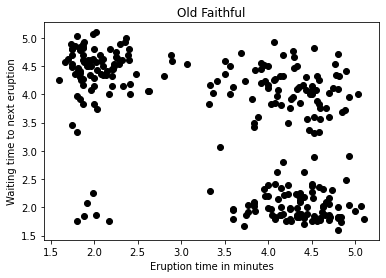

In [26]:
faithful = pd.read_csv('faithful.csv')
plt.plot(faithful.current, faithful.next, 'ko')
plt.xlabel('Eruption time in minutes')
plt.ylabel('Waiting time to next eruption')
plt.title('Old Faithful')

In [27]:
data_faithful = faithful.to_numpy()

In [28]:
def compute_elbow(data, clusters, centers, k):
    """
    """
    E = 0
    for i in range(0, k):
        distance = compute_distance(data[clusters == i, :], centers[i, :].reshape(1, -1), 1)
        E = E + np.mean(np.square(distance))
    return E

Compute the value of E for different values of the number of clusters

In [29]:
E = np.zeros(8)
for k in range(1, 9):
    (clusters, objective, centers) = kmeans_pp(data_faithful, k)
    E[k - 1] = compute_elbow(data_faithful, clusters, centers, k)

Plot $E$ as a function of $k$ and see where reaches a minimum.

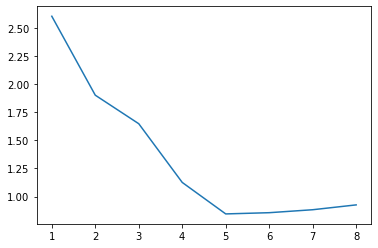

In [30]:
plt.plot(np.arange(1, 9), E)

The elbow method does not always work very well. For example, see what happens when the points get closer to each other.

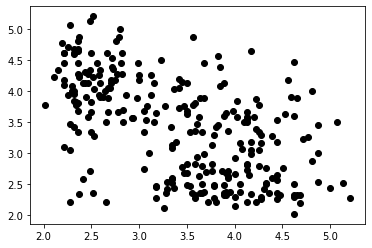

In [31]:
alpha = 0.5
origin = np.array([3, 3])
data_shrink = origin + alpha * np.sign(data_faithful - origin) * np.power(np.abs(data_faithful - origin), 2.0)
plt.plot(data_shrink[:, 0], data_shrink[:, 1], 'ko')

In [32]:
E = np.zeros(8)
for k in range(1, 9):
    (clusters, objective, centers) = kmeans_pp(data_shrink, k)
    E[k - 1] = compute_elbow(data_shrink, clusters, centers, k)

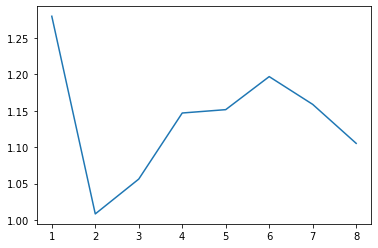

In [33]:
plt.plot(np.arange(1, 9), E)

Let us see what happens when we decrease the number of data

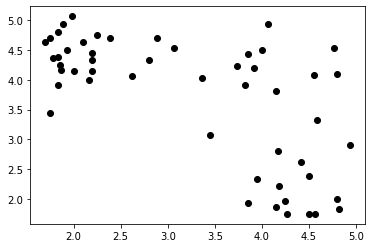

In [34]:
alpha = 0.2
indices = np.random.uniform(size=np.shape(data_faithful)[0])
subdata = data_faithful[indices < alpha, :]
plt.plot(subdata[:, 0], subdata[:, 1], 'ko')

In [35]:
E = np.zeros(8)
for k in range(1, 9):
    (clusters, objective, centers) = kmeans_pp(subdata, k)
    E[k - 1] = compute_elbow(subdata, clusters, centers, k)

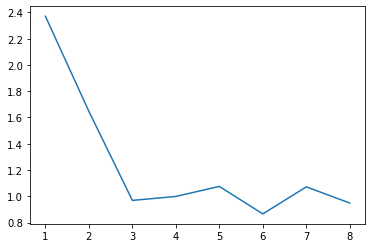

In [36]:
plt.plot(np.arange(1, 9), E)

## PCA before clustering

Let us generate synthetics data.

(-6.0, 3.0)

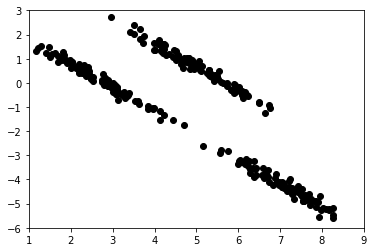

In [37]:
centers = np.array([[2, 2], [2, 8], [4, 3]])
radius = [0.1, 1]
synthetics = np.empty([0, 2])
for i in range(0, 3):
    X = centers[i, 0] + radius[0] * np.random.randn(100)
    Y = centers[i, 1] + radius[1] * np.random.randn(100)
    U = (X + Y) * sqrt(2) / 2
    V = (X - Y) * sqrt(2) / 2
    synthetics = np.concatenate([synthetics, np.vstack((U, V)).T])
plt.plot(synthetics[:,0], synthetics[:,1], 'ko')
plt.xlim(1, 9)
plt.ylim(-6, 3)

Let us now do k-means clustering with 3 clusters.

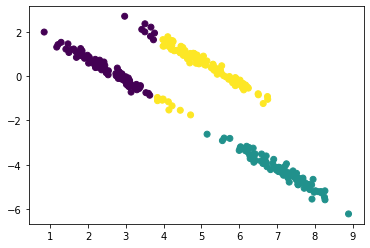

In [38]:
random.seed(0)
(clusters, objective, centers) = kmeans_pp(synthetics, 3)
plt.scatter(synthetics[:,0], synthetics[:,1], c=clusters)

What happens if we apply PCA + normalization before the clustering?

In [39]:
pca = PCA(n_components=2)
synthetics_pca = pca.fit_transform(synthetics)

In [40]:
scaler = preprocessing.StandardScaler().fit(synthetics_pca)
synthetics_scaled = scaler.transform(synthetics_pca)

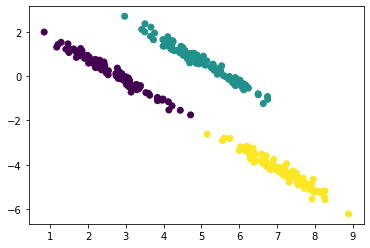

In [41]:
(clusters, objective, centers) = kmeans_pp(synthetics_scaled, 3)
plt.scatter(synthetics[:,0], synthetics[:,1], c=clusters)

We can now retrieve the initial three clusters. Let us see what happens if we apply the same technique to the PNSN catalog.

In [42]:
data = catalog.to_numpy()

In [43]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

In [44]:
scaler = preprocessing.StandardScaler().fit(data_pca)
data_scaled = scaler.transform(data_pca)

Text(0.5, 0.92, 'Clusters for PNSN catalog')

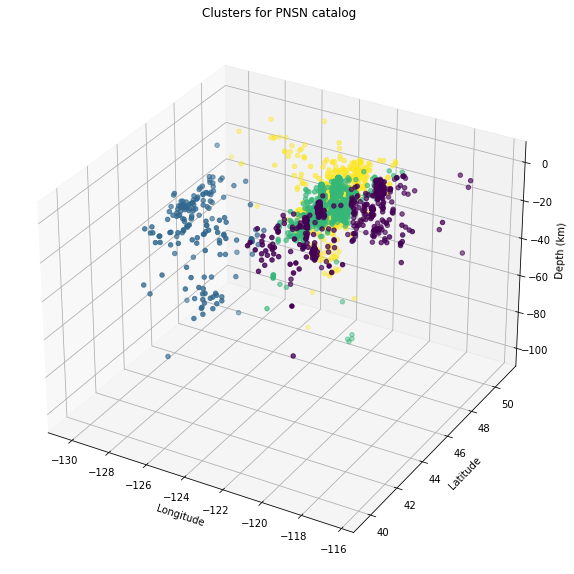

In [45]:
(clusters, objective, centers) = kmeans_pp(data_scaled, 4)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 0], -data[:, 2], c=clusters)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
plt.title('Clusters for PNSN catalog')